In [1]:
import pywt
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from skimage import morphology
from skimage.measure import label, regionprops_table
import pandas as pd
import napari
from napari.utils import nbscreenshot
from scipy.interpolate import make_interp_spline
from sklearn.ensemble import RandomForestClassifier
from dtaidistance import dtw, preprocessing
from collections import defaultdict
from scipy.sparse import csr_matrix

## Random Composite Signal Generation

In [2]:
seed = 42
np.random.seed(seed)


n_samples = 500
freq = 5
time = np.linspace(0, 1, n_samples)

* Signal1: gaussian
* Signal2: Cardiac AP
* Signal3: Decreasing Monoexponential

C:\Users\mazo260d\AppData\Local\Temp\ipykernel_7496\2929572496.py:2: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  signal1 = signal.gaussian(30, std=3)


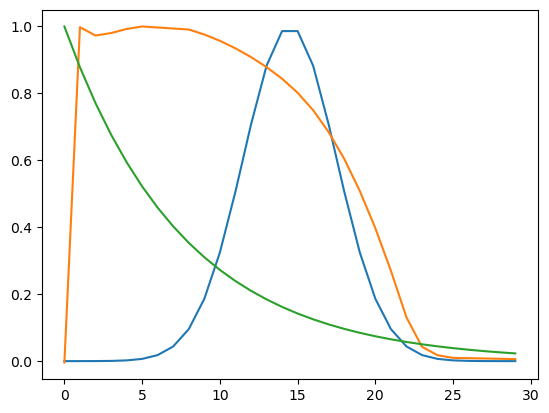

In [3]:
# Signal1: Gaussian
signal1 = signal.gaussian(30, std=3)

# Signal2: Cardiac Ventricular Action Potential
AP_original = np.loadtxt(r"C:\Users\mazo260d\Documents\GitHub\metroid\Simulated_Data\AP.txt",delimiter='\t')
time_sub = np.linspace(0, 5, n_samples) #time vector

# Re-sample at a constant sampling frequency
AP_original[:,0] = AP_original[:,0]/1000                       #ms to sec
xvals = np.arange(AP_original[0,0], AP_original[-1,0], 0.0001) #generate a time vetor with a constant sampling frequency
yinterp = np.interp(xvals, AP_original[:,0], AP_original[:,1]) #interpolate values where original AP time data is missing

# Re-sample by number of samples
yinterp1 = np.interp(time_sub, xvals, yinterp)   #interpolate (extend) data to whole time vector
# Normalize
signal2 = yinterp1
signal2 = signal2+abs(signal2[-1])                          #shift amp from ~-80 to 0
signal2 = signal2/np.amax(signal2)                          #normalize amplitude
# Crop
signal2 = signal2[:30]

# Signal3: Decreasing Monoexponential
def monoexp(x, a, b):
    return a * np.exp(-b * x)
b=0.13
a=1
x = np.arange(30)
signal3 = monoexp(x, a, b)

signals_dict = {0: signal1,
                1: signal2,
                2: signal3}

plt.plot(signal1)
plt.plot(signal2)
plt.plot(signal3)

## Make a random signal composition by adding the three signals with random amplitudes and time shifts

In [4]:
def generate_random_signal_composition(signals_dict, n_samples=500, min_gap=5, max_gap=100):
    composite_signal = np.zeros(n_samples)
    
    position = 0
    while position < n_samples:
        start = position
        # width = np.random.randint(min_width, max(min(max_width, n_samples - position), min_width + 1) + 1)
        signal = signals_dict[np.random.randint(low=0, high=len(signals_dict))]
        width = min(len(signal), n_samples - position)
        composite_signal[start:start+width] = signal[:width]
        position += width + np.random.randint(min_gap, max_gap)  # Move to the end of that window and add some space

    return composite_signal

In [5]:
composite_signal = generate_random_signal_composition(signals_dict=signals_dict)

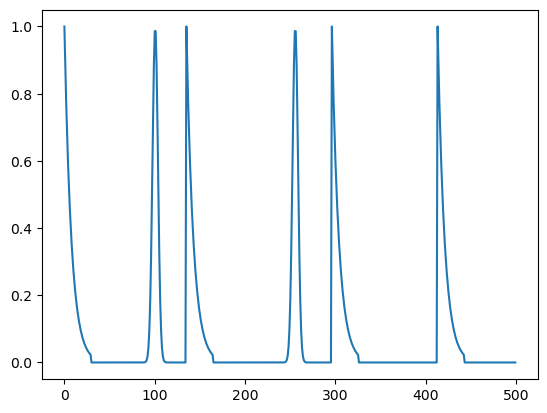

In [6]:
plt.plot(composite_signal)

## Generate random objects

In [7]:
# Generate objects

disk = morphology.disk(4)
square = morphology.square(9)
square[square == 1] = 2
diamond = morphology.diamond(4)
diamond[diamond == 1] = 3
objects_list = [disk, square, diamond]
image = np.zeros((100, 100))
object_order = []
for i in range(10):
    for j in range(3):
        n = np.random.randint(low=2, high=5)
        # obj = objects_list[n]
        obj = morphology.disk(n)
        image[i * 10: i * 10 + (n*2 + 1), 20 + j * 20: 20 + j * 20 + (n*2 + 1)] = obj
        object_order.append(n)

## Add composite signals to objects

In [8]:
# Add signals to label image

label_image = label(image)
height, width = image.shape
time_points = n_samples
time_lapse = np.zeros((time_points, height, width))
for i in range(label_image.max()):
    # print(object_order[i])
    # for label in [1, 2, 3]:
    mask = (label_image == i + 1)  # create boolean mask for current label
    # current_signal = signals[object_order[i]]  # get corresponding signal for current label
    current_signal_category = generate_random_signal_composition(signals_dict)

    # Add random phase by shifting signal
    random_shift = np.random.random()
    current_signal_category = np.roll(current_signal_category, int(random_shift * len(current_signal_category)))

    
    # Add random offset
    current_signal_category = current_signal_category + np.random.random() * 5

    # # Add random window pulses
    # random_windows = generate_random_window_mask()
    # current_signal[~random_windows] = 0

    # Add random noise
    current_signal_category = current_signal_category + np.random.random(size=len(current_signal_category)) / 10

    time_lapse[:, mask] = current_signal_category.reshape((time_points, -1))  # assign signal to region corresponding to current label

## Add mean_intensities of random objects over time to a table

In [9]:
df = pd.DataFrame([])
for i in range(time_points):
    features = regionprops_table(label_image, intensity_image=time_lapse[i], properties=('label', 'mean_intensity'))
    features['frame'] = i
    # data = features.values()
    df = pd.concat([df, pd.DataFrame(features)])

In [10]:
df

,label,mean_intensity,frame
0,1,3.477317,0
1,2,2.538447,0
2,3,1.398264,0
3,4,0.913758,0
4,5,0.505126,0
...,...,...,...
25,26,3.999081,499
26,27,0.277202,499
27,28,0.559926,499
28,29,3.634906,499


## Add data to napari

In [11]:
# viewer = napari.Viewer()
# averages = np.mean(time_lapse, axis=(1, 2))
# viewer.add_image(time_lapse, name='time-lapse')
# table = df

# viewer.add_labels(label_image, features=table, name='labels')

## Annotate some signals

![](./screenshots/signal_annotations1.png)

![](./screenshots/signal_annotations2.png)

In [12]:
# nbscreenshot(viewer)

In [13]:
# nbscreenshot(viewer)

## Save table with annotations to disk

In [14]:
# table = viewer.layers[-1].features

# table.to_csv('table_with_annotations.csv')

table = pd.read_csv('table_with_annotations.csv')
table

,Unnamed: 0,label,mean_intensity,frame,Annotations
0,0,1,3.477317,0,0
1,1,2,2.538447,0,0
2,2,3,1.398264,0,0
3,3,4,0.913758,0,0
4,4,5,0.505126,0,0
...,...,...,...,...,...
14995,14995,26,3.999081,499,0
14996,14996,27,0.277202,499,0
14997,14997,28,0.559926,499,0
14998,14998,29,3.634906,499,0


## Get training data

Get labels where some annotations are present

In [15]:
annotations_mask = table['Annotations'] != 0
labels_with_annotations = np.unique(table[annotations_mask]['label'].values)
labels_with_annotations

array([1, 2, 3], dtype=int64)

In [16]:
# get table rows where label matches labels_with_annotations
table_training = table[table['label'].isin(labels_with_annotations)].sort_values(by=['label', 'frame']).reset_index(drop=True).iloc[:, 1:]
table_training

,label,mean_intensity,frame,Annotations
0,1,3.477317,0,0
1,1,3.499637,1,0
2,1,3.433654,2,0
3,1,3.455424,3,0
4,1,3.434541,4,0
...,...,...,...,...
1495,3,1.375912,495,0
1496,3,1.394512,496,0
1497,3,1.449024,497,0
1498,3,1.435429,498,0


## Extract Sub-Signals

In [17]:
# class SubSignal:
#     def __init__(self, data, category, label, start_frame, end_frame):
#         self.data = data  # The signal data
#         self.category = category  # The class/annotation of the signal
#         self.label = label  # The label of the signal
#         self.start_frame = start_frame  # The starting frame of the signal segment
#         self.end_frame = end_frame  # The ending frame of the signal segment

#     def __repr__(self):
#         return f"<SignalSegment category={self.category}, label={self.label}, frames=[{self.start_frame}:{self.end_frame}), data_length={len(self.data)}>"

# class SubSignalCollection:
#     def __init__(self):
#         self.sub_signals = []
#         self.categories = []
#         self.max_length_per_category = defaultdict(int)

#     def add_sub_signal(self, sub_signal):
#         self.sub_signals.append(sub_signal)
#         if sub_signal.category not in self.categories:
#             self.categories.append(sub_signal.category)
#         self.max_length_per_category[sub_signal.category] = max(self.max_length_per_category[sub_signal.category], len(sub_signal.data))
    
#     def __repr__(self):
#         return f"<SubSignalCollection signal categories={self.categories}, number of signals={len(self.sub_signals)}>"
    
#     def sort_by_category(self):
#         self.sub_signals = sorted(self.sub_signals, key=lambda x: x.category)

class SubSignal:
    _id_counter = 0  # Class variable to keep track of the last assigned ID
    def __init__(self, data, category, label, start_frame, end_frame):
        self.data = data  # The signal data as a numpy array
        self.category = category  # The class/annotation of the signal
        self.label = label  # The label of the signal
        self.start_frame = start_frame  # The starting frame of the signal segment
        self.end_frame = end_frame  # The ending frame of the signal segment
        self.id = SubSignal._get_next_id()  # Assign a unique ID

    @classmethod
    def _get_next_id(cls):
        cls._id_counter += 1
        return cls._id_counter

    def __repr__(self):
        return f"<SignalSegment id={self.id}, category={self.category}, label={self.label}, frames=[{self.start_frame}:{self.end_frame}), data_length={len(self.data)}>"

    def to_slice(self):
        return slice(self.start_frame, self.end_frame)

    def overlaps(self, other, threshold):
        range1 = set(range(self.start_frame, self.end_frame))
        range2 = set(range(other.start_frame, other.end_frame))
        intersection = len(range1.intersection(range2))
        union = len(range1.union(range2))
        jaccard_index = intersection / union if union else 0
        return jaccard_index > threshold

    def merge(self, other):
        new_start_frame = min(self.start_frame, other.start_frame)
        new_end_frame = max(self.end_frame, other.end_frame)
        new_length = new_end_frame + 1 - new_start_frame

        new_data = np.zeros(new_length)
        # Place the current data in the new_data array
        new_data[self.start_frame - new_start_frame:self.end_frame + 1 - new_start_frame] = self.data
        
        # Calculate the slice for the other data
        other_slice_start = other.start_frame - new_start_frame
        other_slice_end = other.end_frame + 1 - new_start_frame

        # Ensure the slices are correctly aligned
        new_data[other_slice_start:other_slice_end] = other.data

        self.data = new_data
        self.start_frame = new_start_frame
        self.end_frame = new_end_frame
        self.id = SubSignal._get_next_id()  # Assign a new unique ID to the merged result

    def interpolate_samples(self, n_samples):
        # Resample the signal segment to a fixed number of samples using spline interpolation
        x = np.arange(len(self.data))
        x_new = np.linspace(0, len(self.data), n_samples)
        spline = make_interp_spline(x, self.data, k=3)
        return spline(x_new)

class SubSignalCollection:
    def __init__(self):
        self.sub_signals = []
        self.categories = []
        self.max_length_per_category = defaultdict(int)

    def add_sub_signal(self, sub_signal):
        self.sub_signals.append(sub_signal)
        if sub_signal.category not in self.categories:
            self.categories.append(sub_signal.category)
        self.max_length_per_category[sub_signal.category] = max(self.max_length_per_category[sub_signal.category], len(sub_signal.data))
    
    def __repr__(self):
        return f"<SubSignalCollection signal categories={self.categories}, number of signals={len(self.sub_signals)}>"

    def sort_by_category(self):
        self.sub_signals = sorted(self.sub_signals, key=lambda x: x.category)

    def merge_subsignals(self, threshold):
        merged = []
        for subsignal in self.sub_signals:
            merged_with_existing = False
            for m in merged:
                if subsignal.label == m.label and subsignal.overlaps(m, threshold): # and subsignal.category != m.category
                    m.merge(subsignal)
                    m.category = f"{m.category}-{subsignal.category}"
                    merged_with_existing = True
                    break
            if not merged_with_existing:
                merged.append(subsignal)
        self.sub_signals = merged
    

def extract_sub_signals_by_annotations(df, column_signal_value, column_signal_id, column_signal_annotation, column_frame):
    """
    Extracts sub-signals from a signal data array based on annotations.

    Parameters
    ----------
    df : pd.DataFrame
        The DataFrame containing the signal data.
    column_signal_value : str
        The column name containing the signal data.
    column_signal_id : str
        The column name containing the signal ID (usually the label from image).
    column_signal_annotation : str
        The column name containing the signal annotations.
    column_frame : str
        The column name containing the frame information (time).
    
    Returns
    -------
    list
        A list of SignalSegment objects.
    """
    data = df[column_signal_value].values
    annotations = df[column_signal_annotation].values
    labels = df[column_signal_id].values
    frames = df[column_frame].values
    return extract_sub_signals_by_annotations_from_arrays(data, annotations, labels, frames)

# The code below is much slower, it is best to get array and process them than using the DataFrame directly
    # sub_signal_collection = SubSignalCollection()
    # current_signal_category = 0
    # start_index = None
    # annotations = df[column_signal_annotation].values

    # # for i, row in df.iterrows():
    # for i, ann in enumerate(annotations):
    #     if ann > 0:  # Signal detected
    #         if current_signal_category == 0:  # New signal starts
    #             current_signal_category = ann
    #             start_index = i
    #         elif current_signal_category != ann:  # Different signal detected, save previous
    #             # Adjusted to include label and frame information
    #             sub_signal = SubSignal(df[column_signal_value].iloc[start_index:i].values, 
    #                                    current_signal_category, 
    #                                    df[column_signal_id].iloc[start_index], 
    #                                    df[column_frame].iloc[start_index], 
    #                                    df[column_frame].iloc[i])
    #             sub_signal_collection.add_sub_signal(sub_signal)
                
    #             current_signal_category = ann
    #             start_index = i
    #     else:  # Noise detected, save previous signal
    #         if current_signal_category > 0:
    #             sub_signal = SubSignal(df[column_signal_value].iloc[start_index:i].values, 
    #                                    current_signal_category, 
    #                                    df[column_signal_id].iloc[start_index], 
    #                                    df[column_frame].iloc[start_index], 
    #                                    df[column_frame].iloc[i])
    #             sub_signal_collection.add_sub_signal(sub_signal)
                
    #             current_signal_category = 0
    #             start_index = None
    
    # # Handle the case where the last signal goes until the end
    # if current_signal_category > 0:
    #     sub_signal = SubSignal(df[column_signal_value].iloc[start_index:].values, 
    #                                    current_signal_category, 
    #                                    df[column_signal_id].iloc[start_index], 
    #                                    df[column_frame].iloc[start_index], 
    #                                    df[column_frame].iloc[-1])
    #     sub_signal_collection.add_sub_signal(sub_signal)
    
    # return sub_signal_collection

def extract_sub_signals_by_annotations_from_arrays(data, annotations, labels, frames):
    """
    Extracts sub-signals from a signal data array based on annotations.

    Parameters
    ----------
    data : np.ndarray
        The signal data array.
    annotations : np.ndarray
        The annotations array.
    labels : np.ndarray
        The labels array.
    frames : np.ndarray
        The frames array.
    
    Returns
    -------
    list
        A list of SignalSegment objects.
    """
    sub_signal_collection = SubSignalCollection()
    sub_signals_list = []
    current_signal_category = 0
    start_index = None

    for i, ann in enumerate(annotations):
        if ann > 0:  # Signal detected
            if current_signal_category == 0:  # New signal starts
                current_signal_category = ann
                start_index = i
            elif current_signal_category != ann:  # Different signal detected, save previous
                # Adjusted to include label and frame information
                sub_signal = SubSignal(data[start_index:i], 
                                       current_signal_category, 
                                       labels[start_index], 
                                       frames[start_index], 
                                       frames[i])
                sub_signal_collection.add_sub_signal(sub_signal)
                
                current_signal_category = ann
                start_index = i
        else:  # Noise detected, save previous signal
            if current_signal_category > 0:
                sub_signal = SubSignal(data[start_index:i],
                                       current_signal_category,
                                       labels[start_index],
                                       frames[start_index],
                                       frames[i])
                sub_signal_collection.add_sub_signal(sub_signal)
                
                current_signal_category = 0
                start_index = None
    
    # Handle the case where the last signal goes until the end
    if current_signal_category > 0:
        sub_signal = SubSignal(data[start_index:],
                               current_signal_category,
                               labels[start_index],
                               frames[start_index],
                               frames[-1])
        sub_signal_collection.add_sub_signal(sub_signal)
    
    return sub_signal_collection


In [18]:
# Optional small test
# data1 = np.array([0, 1, 2, 0, 0, 3, 4, 5, 0, 6, 0, 1, 2, 0, 0, 0, 6, 0]) # intensity values
# annotations1 = np.array([0, 1, 1, 0, 0, 2, 2, 2, 0, 3, 0, 1, 1, 0, 0, 0, 3, 0])
# label1 = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2])
# frame1 = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 0, 1, 2, 3, 4, 5, 6, 7, 8])
# df = pd.DataFrame({'mean_intensity': data1, 'Annotations': annotations1, 'label': label1, 'frame': frame1})

In [19]:
data = table_training['mean_intensity'].values
annotations = table_training['Annotations'].values
labels = table_training['label'].values
frames = table_training['frame'].values

In [20]:
%%timeit
sub_signal_collection = extract_sub_signals_by_annotations(table_training, 'mean_intensity', 'label', 'Annotations', 'frame')

270 µs ± 33.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [21]:
%%timeit
sub_signal_collection = extract_sub_signals_by_annotations_from_arrays(data, annotations, labels, frames)

230 µs ± 2.97 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [22]:
sub_signal_collection_train = extract_sub_signals_by_annotations(table_training, 'mean_intensity', 'label', 'Annotations', 'frame')
sub_signal_collection_train

<SubSignalCollection signal categories=[1, 2, 3], number of signals=17>

## Calculate features for each annotated signal and put them in a table

Sub_signals may have different lengths depending on the user annotations.

In [23]:
n_samples = max(sub_signal_collection_train.max_length_per_category.values())
n_samples

32

In [24]:
# sub_signal_collection.sub_signals

Use spline interpolation to make all sub_signals have the same length under the corresponding category.
Put resampled signals in a table.

In [25]:
# def interpolate_samples(signal, n_samples):
#     # Resample the signal segment to a fixed number of samples using spline interpolation
#     x = np.arange(len(signal))
#     x_new = np.linspace(0, len(signal), n_samples)
#     spline = make_interp_spline(x, signal, k=3)
#     return spline(x_new)

In [26]:
table_training_resampled = pd.DataFrame([])
for i, sub_signal in enumerate(sub_signal_collection_train.sub_signals):
    sub_table = pd.DataFrame(sub_signal.interpolate_samples(n_samples), columns=['mean_intensity_interpolated'])
    # sub_table = pd.DataFrame(interpolate_samples(sub_signal.data, sub_signal_collection.max_length_per_category[sub_signal.category]), columns=['mean_intensity_interpolated'])
    sub_table['sub_label'] = sub_signal.id# i + 1
    sub_table['original_label'] = sub_signal.label
    sub_table['original_start_frame'] = sub_signal.start_frame
    sub_table['original_end_frame'] = sub_signal.end_frame
    sub_table['frame_resampled'] = np.linspace(sub_signal.start_frame, sub_signal.end_frame, n_samples)
    sub_table['category'] = sub_signal.category

    table_training_resampled = pd.concat([table_training_resampled, sub_table], axis=0)
table_training_resampled

,mean_intensity_interpolated,sub_label,original_label,original_start_frame,original_end_frame,frame_resampled,category
0,3.453399,275775,1,43,74,43.0,1
1,3.479164,275775,1,43,74,44.0,1
2,4.480783,275775,1,43,74,45.0,1
3,4.448369,275775,1,43,74,46.0,1
4,4.424114,275775,1,43,74,47.0,1
...,...,...,...,...,...,...,...
27,1.428026,275791,3,448,479,475.0,2
28,1.494664,275791,3,448,479,476.0,2
29,1.482570,275791,3,448,479,477.0,2
30,1.415668,275791,3,448,479,478.0,2


## Extract sub_signal features

use tsfresh to generate sub_signal features table

In [27]:
# tsfresh syntax for extracting features
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

table_training_resampled_minimal = table_training_resampled[['mean_intensity_interpolated', 'sub_label', 'frame_resampled']]

extraction_settings = ComprehensiveFCParameters()

signal_features_table_training = extract_features(table_training_resampled_minimal, column_id='sub_label', column_sort='frame_resampled',
                     default_fc_parameters=extraction_settings,
                     # we impute = remove all NaN features automatically
                     impute_function=impute)

Feature Extraction: 100%|██████████| 17/17 [00:16<00:00,  1.03it/s]


In [28]:
signal_features_table_training

,mean_intensity_interpolated__variance_larger_than_standard_deviation,mean_intensity_interpolated__has_duplicate_max,mean_intensity_interpolated__has_duplicate_min,mean_intensity_interpolated__has_duplicate,mean_intensity_interpolated__sum_values,mean_intensity_interpolated__abs_energy,mean_intensity_interpolated__mean_abs_change,mean_intensity_interpolated__mean_change,mean_intensity_interpolated__mean_second_derivative_central,mean_intensity_interpolated__median,...,mean_intensity_interpolated__fourier_entropy__bins_5,mean_intensity_interpolated__fourier_entropy__bins_10,mean_intensity_interpolated__fourier_entropy__bins_100,mean_intensity_interpolated__permutation_entropy__dimension_3__tau_1,mean_intensity_interpolated__permutation_entropy__dimension_4__tau_1,mean_intensity_interpolated__permutation_entropy__dimension_5__tau_1,mean_intensity_interpolated__permutation_entropy__dimension_6__tau_1,mean_intensity_interpolated__permutation_entropy__dimension_7__tau_1,mean_intensity_interpolated__query_similarity_count__query_None__threshold_0.0,mean_intensity_interpolated__mean_n_absolute_max__number_of_maxima_7
275775,0.0,0.0,0.0,0.0,128.659991,522.925502,0.081638,0.000426,-0.000185,4.193197,...,0.223718,0.578325,0.871781,1.514278,2.237126,2.682016,2.885083,3.044820,0.0,4.476254
275776,0.0,0.0,0.0,0.0,119.999916,452.596621,0.088432,-0.003723,-0.003527,3.652348,...,0.223718,0.443757,0.885289,1.436829,2.195649,2.576443,2.791342,2.844614,0.0,4.202124
275777,0.0,0.0,0.0,0.0,121.322724,463.977564,0.076574,-0.008784,-0.003394,3.633539,...,0.659872,0.659872,0.871781,1.187224,1.574207,1.973865,2.165260,2.308761,0.0,4.341924
275778,0.0,0.0,0.0,0.0,118.658982,442.293133,0.082028,0.005648,0.003175,3.607866,...,0.223718,0.223718,0.885289,1.477087,2.220018,2.642169,2.936427,3.131334,0.0,4.144616
275779,0.0,0.0,0.0,0.0,121.178887,463.035629,0.077698,-0.008034,-0.002966,3.620959,...,0.659872,0.659872,0.871781,1.383562,1.920546,2.309739,2.499499,2.639082,0.0,4.364678
275780,0.0,0.0,0.0,0.0,130.225233,535.638883,0.083426,-0.005562,-0.001356,4.296854,...,0.443757,0.443757,0.871781,1.004099,1.342574,1.474108,1.511962,1.551888,0.0,4.484893
275781,0.0,0.0,0.0,0.0,127.741764,515.859213,0.079952,-0.001402,-0.000553,4.116691,...,0.443757,0.659872,0.871781,1.534027,2.334285,2.738078,2.791342,2.844614,0.0,4.452759
275782,0.0,0.0,0.0,0.0,93.727501,278.648197,0.072188,0.003474,0.001715,2.809412,...,0.659872,0.659872,0.871781,1.320852,1.779306,2.031828,2.175211,2.320715,0.0,3.470990
275783,0.0,0.0,0.0,0.0,99.674720,316.317221,0.096000,-0.004351,-0.003514,3.302937,...,0.443757,0.443757,0.871781,1.526806,2.081999,2.340664,2.443028,2.497519,0.0,3.554332
275784,0.0,0.0,0.0,0.0,91.242449,264.465096,0.077226,-0.006403,-0.003032,2.687080,...,0.659872,0.659872,0.871781,1.053210,1.423496,1.683923,1.826897,1.973620,0.0,3.444199


Annotations are signal categories

In [29]:
annotations = [sub_sig.category for sub_sig in sub_signal_collection_train.sub_signals]
annotations


[1, 2, 3, 2, 3, 1, 1, 3, 1, 3, 1, 2, 1, 1, 2, 3, 2]

### Train Classifier

In [30]:
random_state = 42
classifier = RandomForestClassifier(random_state=random_state)
classifier_path = 'sub_signal_classifier.pkl'

# X_train = signal_features_table_training.iloc[:, 1:] # remove the first column (the object_id)

# # imput mean to handle NaN values
# imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean', add_indicator=False)
# X_imputed_train = imputer.fit_transform(X_train)

classifier.fit(signal_features_table_training, annotations)

train_score = classifier.score(signal_features_table_training, annotations)
print(train_score)

1.0


## Detect regions of interest

### Generate a template per category/annotation from the training data.

**For the alignment, consider applying derivative plus low-pass from dtw if signals have non-flat offsets. (check example [here](https://dtaidistance.readthedocs.io/en/latest/usage/clustering.html#k-means-dba-clustering))**

In [31]:
def normalize(signal, method='minmax'):
    if method == 'zscore':
        return (signal - np.mean(signal)) / np.std(signal)
    elif method == 'minmax':
        return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))
    else:
        raise ValueError(f"Unknown normalization method: {method}")

def align_signals(reference, signal, detrend=False, smooth=0.1):
    if detrend:
        signal_warp = preprocessing.differencing(signal, smooth=smooth)
        reference_warp = preprocessing.differencing(reference, smooth=smooth)
    else:
        signal_warp = signal
        reference_warp = reference
    alignment = dtw.warping_path_fast(reference_warp, signal_warp)
    
    aligned_signal = np.zeros_like(reference)
    for (i, j) in alignment:
        aligned_signal[i] = signal[j]
    return aligned_signal

# Function to generate template from replicates using median signal as reference
def generate_template_mean(replicates, plot_results=False, detrend=False, smooth=0.1):

    # Use the median signal as the initial reference
    median_signal = np.median(replicates, axis=0)
    
    # Align all replicates to the median signal
    aligned_replicates = [align_signals(median_signal, rep, detrend, smooth) for rep in replicates]
    # Optionally plot alignment results
    if plot_results:
        fig, ax = plt.subplots()
        for i, arep, rep in zip(range(len(aligned_replicates)), aligned_replicates, replicates):
            if i != len(aligned_replicates) - 1:
                ax.plot(rep, alpha=0.5, color='gray')
                ax.plot(arep, alpha=0.5, color='cyan')
            else:
                ax.plot(rep, alpha=0.5, color='gray', label='replicate')
                ax.plot(arep, alpha=0.5, color='cyan', label='aligned_replicate')
    # Compute the average to form the template
    template = np.mean(aligned_replicates, axis=0)
    if plot_results:
        ax.plot(template, alpha=0.5, color='magenta', label='template_mean', lw=4)
        plt.legend()
    return template

def generate_templates_by_category(sub_signal_collection, plot_results=False, detrend=False, smooth=0.1):
    """
    Generate templates by category from a list of SignalSegment objects.
    
    Parameters
    ----------
    sub_signal_collection : SubSignalCollection
        The collection of signal segments.

    """
    # Sort the signal segments by category
    sub_signal_collection.sort_by_category()
    
    # Initialize variables
    templates_by_category = {}
    current_category = None
    sub_signals_with_current_category = []
    n_samples = max(sub_signal_collection.max_length_per_category.values())

    # Process each signal segment
    for sub_signal in sub_signal_collection.sub_signals:
        if sub_signal.category != current_category:
            # If the category changes, process the current category
            if sub_signals_with_current_category:
                template = generate_template_mean(sub_signals_with_current_category, plot_results, detrend, smooth)
                templates_by_category[current_category] = template
                sub_signals_with_current_category = []

            # Update the current category
            current_category = sub_signal.category

        # Normalize and resample the current segment
        # target_length = sub_signal_collection.max_length_per_category[current_category]
        resampled_norm_data = normalize(sub_signal.interpolate_samples(n_samples), method='zscore')
        sub_signals_with_current_category.append(resampled_norm_data)
    
    # Process the last category
    if sub_signals_with_current_category:
        template = generate_template_mean(sub_signals_with_current_category, plot_results, detrend, smooth)
        templates_by_category[current_category] = template

    return templates_by_category

Benchmark generate_template functions

In [32]:
replicates_for_benchmark = [normalize(sub_signal.interpolate_samples(n_samples)) for sub_signal in sub_signal_collection_train.sub_signals if sub_signal.category == 1]

In [33]:
%%timeit
generate_template_mean(replicates_for_benchmark, plot_results=False)

230 µs ± 15 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


generate template function is quite slow (PCA approach deforms signals)

Plot templates and compare them to the original signals
1. If detrend is True, align by derivative plus low-pass (only useful if sub_signals have a trending baseline)
2. If detrend is Fals, align replicates directly

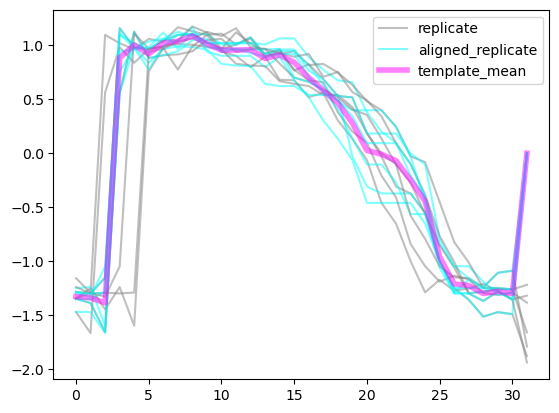

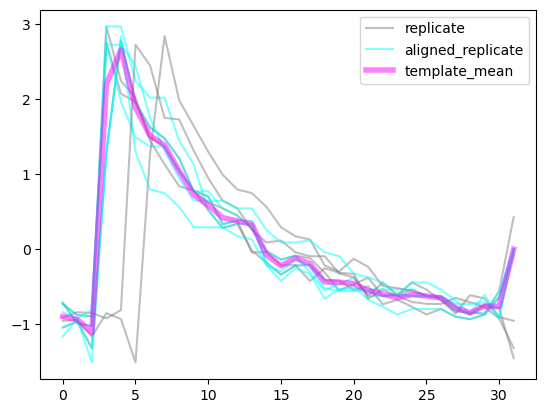

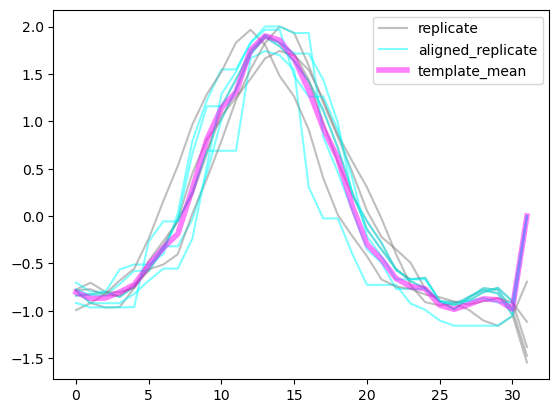

In [34]:
sub_signal_templates = generate_templates_by_category(sub_signal_collection_train, plot_results=True, detrend=True, smooth=0.45)

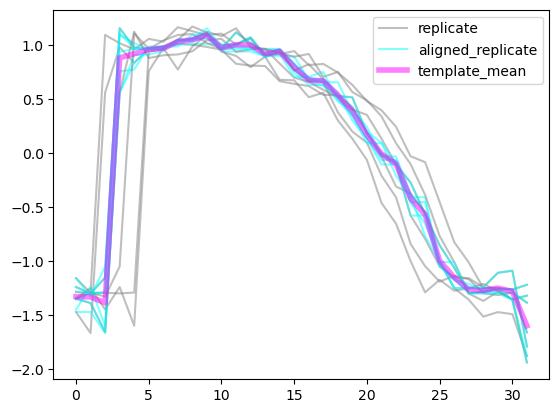

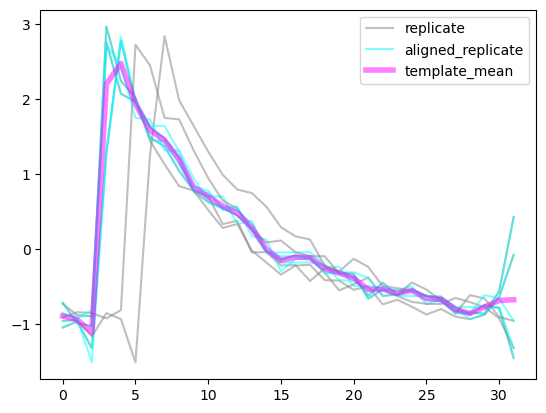

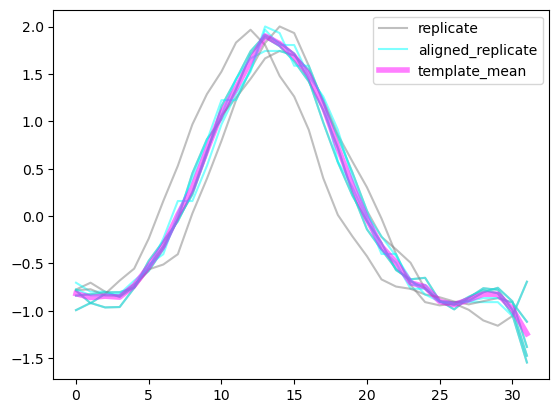

In [35]:
sub_signal_templates = generate_templates_by_category(sub_signal_collection_train, plot_results=True, detrend=False)

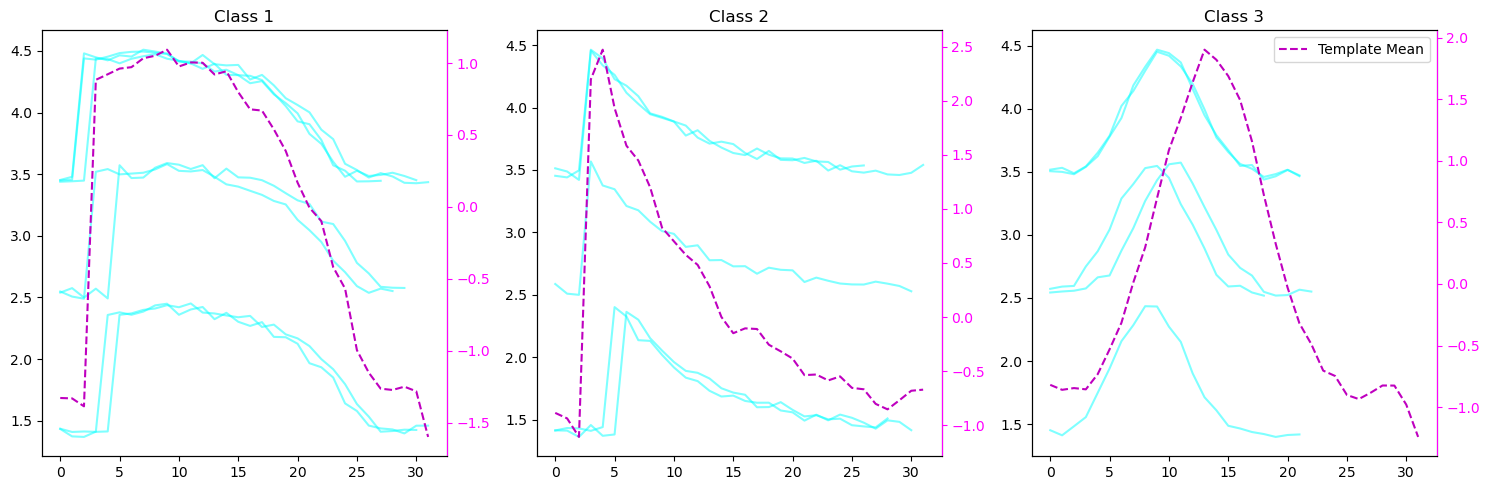

In [36]:
# Plot all signals separated by class in a different column
fig, ax = plt.subplots(1, len(sub_signal_templates), figsize=(15, 5))
for sub_sig in sub_signal_collection_train.sub_signals:
    ax[sub_sig.category-1].plot(sub_sig.data, 'cyan', alpha=0.5)
    ax[sub_sig.category-1].set_title(f'Class {sub_sig.category}')

for i, template_mean in sub_signal_templates.items():
    ax2 = ax[i-1].twinx()
    ax2.yaxis.label.set_color('magenta')
    ax2.tick_params(axis='y', colors='magenta')
    ax2.spines['right'].set_color('magenta')
    ax2.plot(template_mean, 'm--', label='Template Mean')
ax2.legend()
plt.tight_layout()

## Detect regions of interest
Find peaks by thresholding cross-correlation and get a region around them.
Develop some strategy to collect these regions without duplication (or collect duplication, but assign some weight or probability to them)


In [37]:
chosen_label = 6
# in label 10, same class (1) overlaps because sub_signals are too close to each other
# in label 11, same class (3) is detected by two signals that are too close to each other
# in label 6, there is some noise that makes the same sub_signal to be detected twice by the same class with a small shift

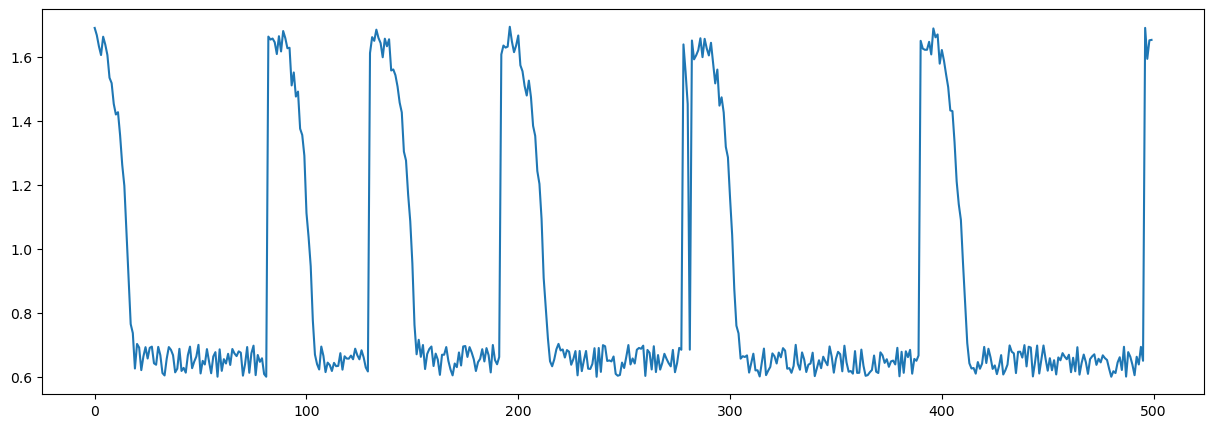

In [38]:
composite_signal1 = table[(table['label'] == chosen_label)].sort_values(by=['label', 'frame']).reset_index(drop=True)['mean_intensity'].values
plt.figure(figsize=(15, 5))
plt.plot(composite_signal1)

Calculate cross-correlation between each normalized signal class and whole normalized annotated composite signal and plot results

In [39]:
sub_signal_collection_train.categories

[1, 2, 3]

In [40]:
len(sub_signal_templates)

3

Next steps:
- check whether this is enough to ID sub_signals (no Random Forest Classifier), but it seems not (it detects more sub_signals per category, check the exponential example below, maybe thresholding it differently could solve it)
- if not, train a classifier to detect sub_signals and find a way to assign unique classes to them
- try wavelet transform to detect sub_signals as an alternative to both methods above

Found 7 peaks for class 1
Found 5 peaks for class 2
Found 5 peaks for class 3


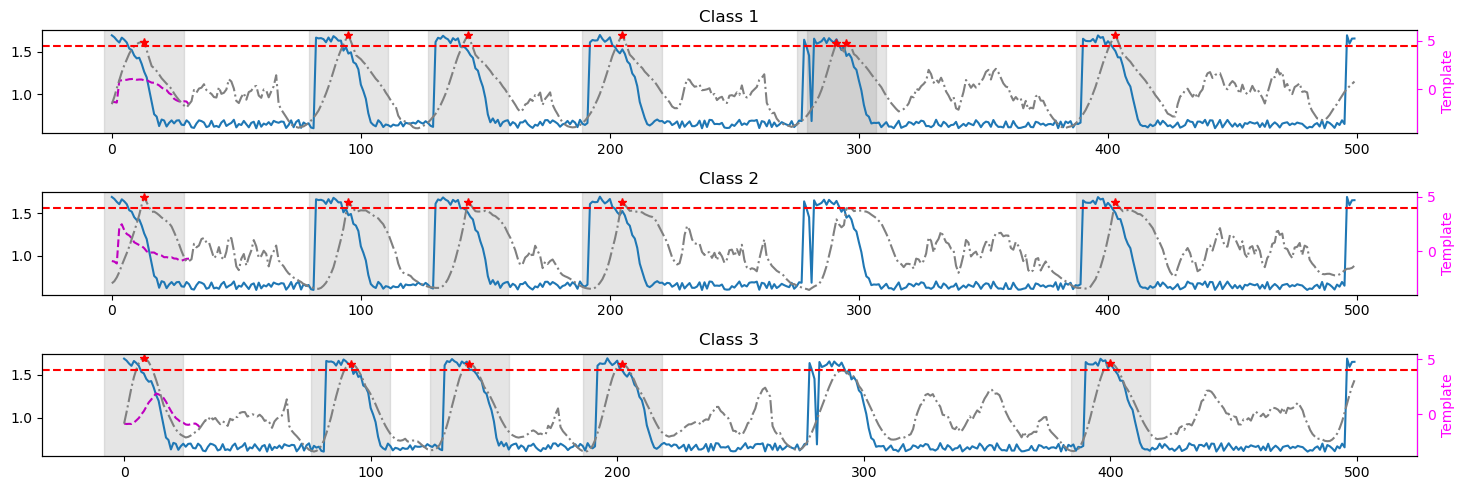

In [41]:
def detect_sub_signal_by_template(composite_signal, template, threshold, return_cross_corr=False, norm_method='minmax'):
    signal_norm = normalize(composite_signal, method=norm_method)
    template_norm = normalize(template, method=norm_method)
    cross_corr = signal.correlate(signal_norm, template_norm, mode='same') # default method already chooses between fft and direct

    if norm_method == 'minmax':
         # Normalizing cross-correlation by minmax directly
        normalized_corr = normalize(cross_corr, method=norm_method)
    elif norm_method == 'zscore':
        # Normalizing cross-correlation by energy of signal and template
        fm2 = signal.correlate(signal_norm**2, np.ones_like(template_norm), mode='same') # Convolution of the squared composite signal with a window of ones
        fm = signal.correlate(signal_norm, np.ones_like(template_norm), mode='same') # Convolution of the composite signal with a window of ones
        n = len(template)
        denominator = np.sqrt(fm2 - fm**2/n)
        normalized_corr = cross_corr/denominator

    threshold = np.max(normalized_corr) * threshold
    peaks_indices, _ = signal.find_peaks(normalized_corr, height=threshold)
    if return_cross_corr:
        return peaks_indices, normalized_corr
    return peaks_indices

threshold=0.8
fig, ax = plt.subplots(len(sub_signal_templates),1, figsize=(15, 5))
for i, sub_signal in enumerate(sub_signal_templates.values()):
    peaks_indices, normalized_cross_corr = detect_sub_signal_by_template(composite_signal1, sub_signal, threshold, return_cross_corr=True, norm_method='zscore')
    ax[i].plot(composite_signal1, label='Composite Signal')
    ax2 = ax[i].twinx()
    ax2.plot(sub_signal, 'm--', label='Template')
    ax2.yaxis.label.set_color('magenta')
    ax2.tick_params(axis='y', colors='magenta')
    ax2.spines['right'].set_color('magenta')
    ax2.set_ylabel('Template', color='magenta')
    ax2.plot(normalized_cross_corr, '-.', color='gray', label='Normalized Cross-Correlation')
    ax2.plot(peaks_indices, normalized_cross_corr[peaks_indices], 'r*', label='Detected Peaks')
    ax2.axhline(y=np.max(normalized_cross_corr)*threshold, color='r', linestyle='--')
    for peak_index in peaks_indices:
        ax[i].axvspan(peak_index-np.floor(len(sub_signal)/2), peak_index+np.floor(len(sub_signal)/2), color='gray', alpha=0.2)
    ax[i].set_title(f'Class {i+1}')
    print(f"Found {len(peaks_indices)} peaks for class {i+1}")
plt.tight_layout()



In [42]:
sub_signal_templates

{1: array([-1.329217  , -1.33216226, -1.38722312,  0.88370093,  0.92228486,
         0.96182852,  0.97173233,  1.03377139,  1.05119964,  1.09330779,
         0.97659935,  1.004902  ,  1.0023545 ,  0.92084362,  0.94331124,
         0.79810669,  0.67857803,  0.66982147,  0.53939418,  0.38901261,
         0.16836232, -0.00561097, -0.09899747, -0.41876656, -0.56798837,
        -0.99664859, -1.15321492, -1.26447186, -1.27343512, -1.25054948,
        -1.28266466, -1.60000651]),
 2: array([-8.86541075e-01, -9.37309155e-01, -1.10862799e+00,  2.19835560e+00,
         2.47237465e+00,  1.93234493e+00,  1.58458033e+00,  1.44767600e+00,
         1.19876941e+00,  8.26269398e-01,  7.00456972e-01,  5.74972982e-01,
         4.82234424e-01,  2.84405378e-01,  9.06730109e-04, -1.49372413e-01,
        -1.04743767e-01, -1.10631524e-01, -2.56011871e-01, -3.17392142e-01,
        -3.83705076e-01, -5.37000697e-01, -5.31498910e-01, -5.86173010e-01,
        -5.49065737e-01, -6.54811994e-01, -6.68356213e-01, -8.03

In [43]:
def extract_sub_signals_by_templates(df, column_signal_value, column_signal_id, column_frame, sub_signal_templates, threshold, method='zscore'):
  
    sub_signal_collection = SubSignalCollection()
    grouped_by_label = df.groupby(column_signal_id, sort=False) # column_signal_id = 'label'
    for label, sub_table in list(grouped_by_label):
        composite_signal = sub_table[column_signal_value].values # column_signal_value = 'mean_intensity'
        # for each composite signal, detect sub_signals using the templates
        for k, template in sub_signal_templates.items():
            peaks_indices = detect_sub_signal_by_template(composite_signal, template, threshold, norm_method=method)
            # Collect the sub_signals around each peak
            for peak_index in peaks_indices:
                # Add the sub_signal to the collection with the template category, original label and frame information
                start_index = int(peak_index-np.floor(len(template)/2))
                end_index = int(peak_index+np.floor(len(template)/2))
                # If sub_signal would start before composite signal, set start frame to 0
                if start_index < 0:
                    start_index = 0
                # If sub_signal would end after composite signal, set end frame to the last frame
                if end_index > len(composite_signal):
                    end_index = len(composite_signal)
                sub_signal = SubSignal(composite_signal[start_index:end_index],
                                    k, 
                                    label, 
                                    sub_table[column_frame].values[start_index], 
                                    sub_table[column_frame].values[end_index-1]
                                    )
                sub_signal_collection.add_sub_signal(sub_signal)
    return sub_signal_collection


In [44]:
sub_signal_collection_test = extract_sub_signals_by_templates(table, 'mean_intensity', 'label', 'frame', sub_signal_templates, threshold)
sub_signal_collection_test

<SubSignalCollection signal categories=[1, 2, 3], number of signals=457>

## Extract signal slices to check for duplicates

Testing below for a chosen label

In [45]:
sub_signal_collection_1 = SubSignalCollection()
for sub_signal in sub_signal_collection_test.sub_signals:
    if sub_signal.label == 6:
        sub_signal_collection_1.add_sub_signal(sub_signal)

In [46]:
sub_signal_collection_1

<SubSignalCollection signal categories=[1, 2, 3], number of signals=17>

In [47]:
sub_signal_collection_1.sub_signals

[<SignalSegment id=275871, category=1, label=6, frames=[0:28), data_length=29>,
 <SignalSegment id=275872, category=1, label=6, frames=[79:110), data_length=32>,
 <SignalSegment id=275873, category=1, label=6, frames=[127:158), data_length=32>,
 <SignalSegment id=275874, category=1, label=6, frames=[189:220), data_length=32>,
 <SignalSegment id=275875, category=1, label=6, frames=[275:306), data_length=32>,
 <SignalSegment id=275876, category=1, label=6, frames=[279:310), data_length=32>,
 <SignalSegment id=275877, category=1, label=6, frames=[387:418), data_length=32>,
 <SignalSegment id=275878, category=2, label=6, frames=[0:28), data_length=29>,
 <SignalSegment id=275879, category=2, label=6, frames=[79:110), data_length=32>,
 <SignalSegment id=275880, category=2, label=6, frames=[127:158), data_length=32>,
 <SignalSegment id=275881, category=2, label=6, frames=[189:220), data_length=32>,
 <SignalSegment id=275882, category=2, label=6, frames=[387:418), data_length=32>,
 <SignalSegm

In [48]:
sub_signal_collection_1.merge_subsignals(0.5)

In [49]:
sub_signal_collection_1

<SubSignalCollection signal categories=[1, 2, 3], number of signals=6>

In [50]:
sub_signal_collection_1.sub_signals

[<SignalSegment id=276255, category=1-2-3, label=6, frames=[0:28), data_length=29>,
 <SignalSegment id=276256, category=1-2-3, label=6, frames=[76:110), data_length=35>,
 <SignalSegment id=276257, category=1-2-3, label=6, frames=[124:158), data_length=35>,
 <SignalSegment id=276258, category=1-2-3, label=6, frames=[186:220), data_length=35>,
 <SignalSegment id=276249, category=1-1, label=6, frames=[275:310), data_length=36>,
 <SignalSegment id=276259, category=1-2-3, label=6, frames=[384:418), data_length=35>]

In [51]:
sub_signal_collection_test.merge_subsignals(0.5)

In [52]:
sub_signal_collection_test

<SubSignalCollection signal categories=[1, 2, 3], number of signals=194>

# Make test_table

In [53]:

# # Example usage
# if __name__ == "__main__":
#     sub_signals = [
#         SubSignal(data=np.array([1, 2, 3]), category='A', label='X', start_frame=4, end_frame=7),
#         SubSignal(data=np.array([4, 5, 6, 7, 8]), category='B', label='X', start_frame=9, end_frame=13),
#         SubSignal(data=np.array([7, 8]), category='A', label='Y', start_frame=0, end_frame=2),
#         SubSignal(data=np.array([9, 10]), category='B', label='X', start_frame=5, end_frame=7),
#         SubSignal(data=np.array([11, 12, 13, 14]), category='A', label='Y', start_frame=11, end_frame=15),
#         SubSignal(data=np.array([14, 15, 16, 17]), category='B', label='X', start_frame=4, end_frame=8)
#     ]

#     collection = SubSignalCollection()
#     for sub_signal in sub_signals:
#         collection.add_sub_signal(sub_signal)

#     threshold = 0.7
#     collection.merge_subsignals(threshold)

#     print("After merging:")
#     for sub_signal in collection.sub_signals:
#         print(sub_signal)

Turn collected signals into a table to extract features with tsfresh
No need to resample them since they were collected via template of fixed length

In [54]:
table_test_set = pd.DataFrame([])
for i, sub_signal in enumerate(sub_signal_collection_test.sub_signals):
    sub_table = pd.DataFrame(sub_signal.data, columns=['mean_intensity'])
    sub_table['sub_label'] = sub_signal.id#i + 1
    sub_table['original_label'] = sub_signal.label
    sub_table['original_start_frame'] = sub_signal.start_frame
    sub_table['original_end_frame'] = sub_signal.end_frame
    sub_table['frame'] = np.arange(sub_signal.start_frame, sub_signal.end_frame + 1)
    sub_table['category'] = 0
    sub_table['template_category'] = sub_signal.category

    table_test_set = pd.concat([table_test_set, sub_table], axis=0)
table_test_set

,mean_intensity,sub_label,original_label,original_start_frame,original_end_frame,frame,category,template_category
0,3.507814,276262,1,39,73,39,0,1-2-3
1,3.501321,276262,1,39,73,40,0,1-2-3
2,3.461263,276262,1,39,73,41,0,1-2-3
3,3.425859,276262,1,39,73,42,0,1-2-3
4,3.453399,276262,1,39,73,43,0,1-2-3
...,...,...,...,...,...,...,...,...
34,1.098567,276522,30,405,443,439,0,2-3
35,1.182985,276522,30,405,443,440,0,2-3
36,1.116839,276522,30,405,443,441,0,2-3
37,1.160974,276522,30,405,443,442,0,2-3


## Extract sub_signal features for test data

In [55]:
table_test_set_minimal = table_test_set[['mean_intensity', 'sub_label', 'frame']]
table_test_set_minimal.columns = ['mean_intensity_interpolated', 'sub_label', 'frame']

extraction_settings = ComprehensiveFCParameters()

signal_features_table_test = extract_features(table_test_set_minimal, column_id='sub_label', column_sort='frame',
                     default_fc_parameters=extraction_settings,
                     # we impute = remove all NaN features automatically
                     impute_function=impute)

Feature Extraction: 100%|██████████| 39/39 [00:20<00:00,  1.89it/s]


In [56]:
# each row is a different sub_signal (which could be replicates due to the template matching process)
signal_features_table_test

,mean_intensity_interpolated__variance_larger_than_standard_deviation,mean_intensity_interpolated__has_duplicate_max,mean_intensity_interpolated__has_duplicate_min,mean_intensity_interpolated__has_duplicate,mean_intensity_interpolated__sum_values,mean_intensity_interpolated__abs_energy,mean_intensity_interpolated__mean_abs_change,mean_intensity_interpolated__mean_change,mean_intensity_interpolated__mean_second_derivative_central,mean_intensity_interpolated__median,...,mean_intensity_interpolated__fourier_entropy__bins_5,mean_intensity_interpolated__fourier_entropy__bins_10,mean_intensity_interpolated__fourier_entropy__bins_100,mean_intensity_interpolated__permutation_entropy__dimension_3__tau_1,mean_intensity_interpolated__permutation_entropy__dimension_4__tau_1,mean_intensity_interpolated__permutation_entropy__dimension_5__tau_1,mean_intensity_interpolated__permutation_entropy__dimension_6__tau_1,mean_intensity_interpolated__permutation_entropy__dimension_7__tau_1,mean_intensity_interpolated__query_similarity_count__query_None__threshold_0.0,mean_intensity_interpolated__mean_n_absolute_max__number_of_maxima_7
275905,0.0,0.0,0.0,0.0,56.189851,179.652415,0.093125,0.054493,-0.000686,3.112973,...,0.639032,0.940448,2.025326,1.630433,2.430791,2.639057,2.564949,2.484907,0.0,3.616954
275965,0.0,0.0,0.0,0.0,65.714984,244.495150,0.089067,0.057669,0.000430,3.657850,...,0.639032,0.940448,2.025326,1.754105,2.176186,2.403640,2.564949,2.484907,0.0,4.163901
276083,0.0,0.0,0.0,0.0,136.668788,587.340699,0.081002,-0.000272,-0.000745,4.073425,...,0.578325,0.871781,1.079162,1.550660,2.264499,2.540036,2.669274,2.791295,0.0,4.848623
276112,0.0,0.0,0.0,0.0,57.065835,138.670973,0.089661,0.001536,-0.001159,2.180489,...,0.793730,0.793730,1.043794,1.053472,1.370108,1.761596,2.086769,2.260204,0.0,2.884151
276126,0.0,0.0,0.0,0.0,100.155468,439.067918,0.098201,0.003345,-0.000539,4.192968,...,0.836988,0.836988,1.098612,1.380759,1.851362,2.097366,2.274241,2.445468,0.0,4.847116
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276518,0.0,0.0,0.0,0.0,37.018286,48.286348,0.051002,-0.025366,-0.000052,1.195351,...,0.485094,0.485094,1.297296,1.405971,2.340840,2.786085,3.040727,3.075221,0.0,1.559691
276519,0.0,0.0,0.0,0.0,56.222637,96.966035,0.072731,-0.000102,0.000423,1.740967,...,0.425848,0.425848,0.837772,1.458664,2.289153,2.796083,2.846680,2.897593,0.0,2.099262
276520,0.0,0.0,0.0,0.0,50.311404,68.778884,0.073570,-0.001614,-0.000063,1.134197,...,0.587501,0.777661,0.964695,1.609619,2.565096,3.007732,3.192742,3.286463,0.0,1.905219
276521,0.0,0.0,0.0,0.0,51.635400,71.576592,0.067281,0.002387,0.000507,1.193084,...,0.708347,0.708347,1.799037,1.654699,2.528511,3.003320,3.210168,3.328472,0.0,1.861961


## Predict sub_signal categories

In [57]:
# predict sub_signal categories
predictions = classifier.predict(signal_features_table_test)

In [58]:
predictions

array([3, 1, 3, 3, 3, 1, 1, 3, 3, 1, 2, 3, 2, 3, 1, 1, 3, 1, 3, 1, 2, 1,
       1, 1, 1, 2, 3, 2, 2, 3, 2, 1, 2, 1, 2, 1, 3, 1, 1, 3, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 2, 1, 1, 3, 1, 2, 3, 1, 1,
       1, 1, 2, 2, 2, 1, 2, 2, 1, 3, 2, 3, 3, 2, 3, 2, 3, 1, 1, 3, 3, 1,
       3, 1, 3, 1, 1, 2, 3, 3, 1, 1, 2, 3, 3, 3, 1, 2, 2, 2, 3, 2, 3, 3,
       2, 2, 1, 1, 3, 3, 3, 2, 3, 3, 3, 1, 3, 1, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 2, 2, 3, 1, 2, 3, 1, 3, 3, 1, 3, 3, 3, 2, 1, 2, 2, 2, 1, 1, 3,
       3, 1, 1, 3, 3, 3, 1, 2, 1, 2, 3, 1, 1, 1, 1, 2, 3, 2, 3, 3, 2, 3,
       3, 3, 2, 2, 3, 3, 1, 2, 2, 3, 1, 1, 1, 2, 1, 3, 2, 2], dtype=int64)

Display them on top of whole signal

In [59]:
# plt.plot(composite_signal1)


Add predictions to table

In [60]:
predictions_series = pd.Series(predictions, index=signal_features_table_test.index)
table_test_set['predicted_category'] = table_test_set['sub_label'].map(predictions_series)
table_test_set

,mean_intensity,sub_label,original_label,original_start_frame,original_end_frame,frame,category,template_category,predicted_category
0,3.507814,276262,1,39,73,39,0,1-2-3,1
1,3.501321,276262,1,39,73,40,0,1-2-3,1
2,3.461263,276262,1,39,73,41,0,1-2-3,1
3,3.425859,276262,1,39,73,42,0,1-2-3,1
4,3.453399,276262,1,39,73,43,0,1-2-3,1
...,...,...,...,...,...,...,...,...,...
34,1.098567,276522,30,405,443,439,0,2-3,2
35,1.182985,276522,30,405,443,440,0,2-3,2
36,1.116839,276522,30,405,443,441,0,2-3,2
37,1.160974,276522,30,405,443,442,0,2-3,2


Find remakining duplicates

In [61]:
# Ensure table_test_set is sorted by frame and original_label
table_test_set = table_test_set.sort_values(by=['original_label', 'frame', 'original_start_frame'])

# Step 1: Identify Duplicates
duplicates = table_test_set[table_test_set.duplicated(subset=['original_label', 'frame'], keep=False)]
duplicates

,mean_intensity,sub_label,original_label,original_start_frame,original_end_frame,frame,category,template_category,predicted_category
31,3.398681,276348,10,128,162,159,0,1-2-3,1
0,3.398681,276349,10,159,193,159,0,1-2-3,1
32,3.331711,276348,10,128,162,160,0,1-2-3,1
1,3.331711,276349,10,159,193,160,0,1-2-3,1
33,3.382049,276348,10,128,162,161,0,1-2-3,1
...,...,...,...,...,...,...,...,...,...
0,0.314163,276498,27,319,357,319,0,1-2-3,2
38,0.324797,276497,27,282,321,320,0,1-2-3,3
1,0.324797,276498,27,319,357,320,0,1-2-3,2
39,0.317158,276497,27,282,321,321,0,1-2-3,3


Re-assign categories to duplicates (half to each category)

In [62]:
def reassign_duplicate_values(tab):
    categories = tab['predicted_category'].values
    left_value = categories[0]
    right_value = categories[-1]
    # Create the new array
    new_categories = np.empty(len(categories) // 2, dtype=np.int64)

    # Fill the first half with the first value of the original array
    new_categories[:len(new_categories)//2] = left_value

    # Fill the second half with the second value of the original array
    new_categories[len(new_categories)//2:] = right_value

    tab = tab.set_index(['frame'])
    return pd.Series(new_categories, index=tab.index[::2])

In [63]:
duplicates_reassigned_series = duplicates.groupby(['original_label']).apply(reassign_duplicate_values)

In [64]:
duplicates_reassigned_series

original_label  frame
10              159      1
                160      1
                161      1
                162      1
11              482      3
                483      3
                484      3
                485      1
                486      1
                487      1
                488      1
16              11       2
                12       2
                13       2
                14       2
                15       2
                16       2
                17       2
                18       2
19              332      3
                333      3
                334      3
                335      2
                336      2
                337      2
24              92       1
                93       1
                94       1
                95       1
                96       1
                97       3
                98       3
                99       3
                100      3
                101      3
                102      3
27    

Drop duplicates from original dataframe

In [65]:
table_test_set = table_test_set.drop_duplicates(subset=['original_label', 'frame'])
table_test_set

,mean_intensity,sub_label,original_label,original_start_frame,original_end_frame,frame,category,template_category,predicted_category
0,3.507814,276262,1,39,73,39,0,1-2-3,1
1,3.501321,276262,1,39,73,40,0,1-2-3,1
2,3.461263,276262,1,39,73,41,0,1-2-3,1
3,3.425859,276262,1,39,73,42,0,1-2-3,1
4,3.453399,276262,1,39,73,43,0,1-2-3,1
...,...,...,...,...,...,...,...,...,...
34,1.098567,276522,30,405,443,439,0,2-3,2
35,1.182985,276522,30,405,443,440,0,2-3,2
36,1.116839,276522,30,405,443,441,0,2-3,2
37,1.160974,276522,30,405,443,442,0,2-3,2


In [66]:
table_test_set[(table_test_set['frame'] == 159).values & (table_test_set['original_label'] == 10).values]

,mean_intensity,sub_label,original_label,original_start_frame,original_end_frame,frame,category,template_category,predicted_category
31,3.398681,276348,10,128,162,159,0,1-2-3,1


In [67]:
table_test_set[(table_test_set['frame'] >= 482).values & (table_test_set['frame'] <= 488).values & (table_test_set['original_label'] == 11).values]

,mean_intensity,sub_label,original_label,original_start_frame,original_end_frame,frame,category,template_category,predicted_category
32,3.175770,276361,11,450,488,482,0,2-3,3
33,3.136186,276361,11,450,488,483,0,2-3,3
34,3.136350,276361,11,450,488,484,0,2-3,3
35,3.135951,276361,11,450,488,485,0,2-3,3
36,3.123227,276361,11,450,488,486,0,2-3,3
37,3.176306,276361,11,450,488,487,0,2-3,3
38,3.201561,276361,11,450,488,488,0,2-3,3


In [68]:
# mapping = Values_df.melt(id_vars='cat', var_name='topic').set_index(['topic', 'cat'])['value']
mapped_values = table_test_set[['original_label', 'frame']].apply(tuple, axis=1).map(duplicates_reassigned_series)
table_test_set.loc[:, 'predicted_category'] = mapped_values.combine_first(table_test_set['predicted_category'])
table_test_set['predicted_category'] = table_test_set['predicted_category'].astype(int)

In [69]:
table_test_set[(table_test_set['frame'] >= 482).values & (table_test_set['frame'] <= 488).values & (table_test_set['original_label'] == 11).values]

,mean_intensity,sub_label,original_label,original_start_frame,original_end_frame,frame,category,template_category,predicted_category
32,3.175770,276361,11,450,488,482,0,2-3,3
33,3.136186,276361,11,450,488,483,0,2-3,3
34,3.136350,276361,11,450,488,484,0,2-3,3
35,3.135951,276361,11,450,488,485,0,2-3,1
36,3.123227,276361,11,450,488,486,0,2-3,1
37,3.176306,276361,11,450,488,487,0,2-3,1
38,3.201561,276361,11,450,488,488,0,2-3,1


In [70]:
new_predictions_series = table_test_set.set_index(['original_label', 'frame'])['predicted_category']
new_predictions_series.index.names = ['label', 'frame']
mapped_values = table[['label', 'frame']].apply(tuple, axis=1).map(new_predictions_series)
table['Predictions'] = mapped_values.fillna(0).astype(int)
# table2.loc[:, 'predicted_category'] = mapped_values.combine_first(table_test_set['predicted_category'])
# table_test_set['predicted_category'] = table_test_set['predicted_category'].astype(int)

In [71]:
table

,Unnamed: 0,label,mean_intensity,frame,Annotations,Predictions
0,0,1,3.477317,0,0,0
1,1,2,2.538447,0,0,0
2,2,3,1.398264,0,0,0
3,3,4,0.913758,0,0,0
4,4,5,0.505126,0,0,0
...,...,...,...,...,...,...
14995,14995,26,3.999081,499,0,3
14996,14996,27,0.277202,499,0,3
14997,14997,28,0.559926,499,0,0
14998,14998,29,3.634906,499,0,0


In [72]:
from napari_signal_selector.interactive import InteractiveFeaturesLineWidget
viewer = napari.Viewer()
averages = np.mean(time_lapse, axis=(1, 2))
viewer.add_image(time_lapse, name='time-lapse')
# table = df

viewer.add_labels(label_image, features=table, name='labels')

widget = InteractiveFeaturesLineWidget(viewer)
viewer.window.add_dock_widget(widget, area='right')

In [73]:
widget.object_id_axis_key = 'label'
widget.x_axis_key = 'frame'
widget.y_axis_key = 'mean_intensity'

In [74]:
widget.update_line_layout_from_column('Predictions')

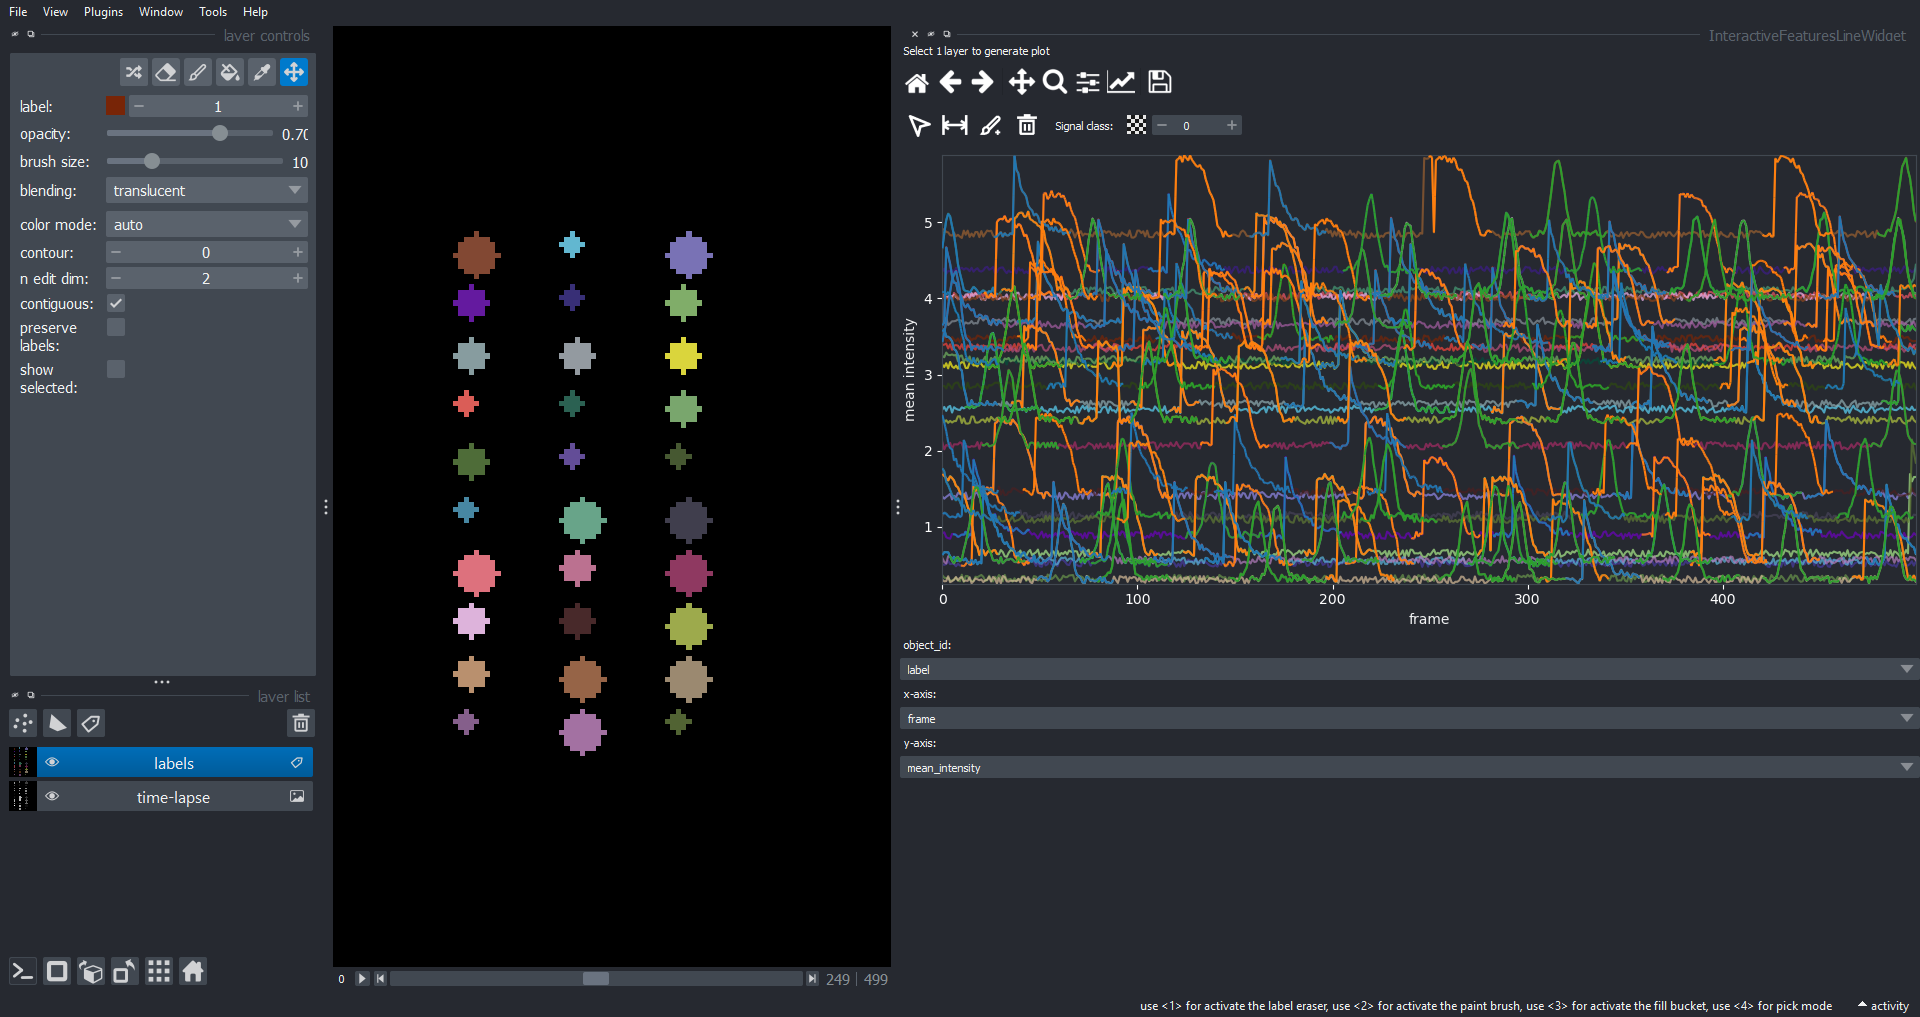

In [75]:
nbscreenshot(viewer)